FAKE NEWS DETECTION

Installing packages


In [ ]:
!pip install nltk
!pip install sklearn


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Importing necessary libraries

In [ ]:
import csv 
import nltk# csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
import re # Regular expression
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from collections import Counter
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Input and Basic Preprocessing

In [ ]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label,text,subject, speaker, speaker_job, state_info, party_affiliation) = parse_data_line(line)
            raw_data.append((text,subject, speaker, speaker_job, state_info, party_affiliation,label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text,subject,speaker,speaker_job,state_info,party_affiliation,label) in raw_data[:num_training_samples]:
        train_data.append((toFeatureVector(pre_process(text,subject,speaker,speaker_job,state_info,party_affiliation)),label))
    for (text,subject,speaker,speaker_job,state_info,party_affiliation,label) in raw_data[num_training_samples:]:
        test_data.append((toFeatureVector(pre_process(text,subject,speaker,speaker_job,state_info,party_affiliation)),label))

In [ ]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    label = data_line[1]
    statement = data_line[2]
    subject = data_line[3]
    speaker = data_line[4]
    speaker_job = data_line[5]
    state_info = data_line[6]
    party_affiliation = data_line[7]
    #context = data_line[12] 
    label = convert_label(label)
    return(label,statement,subject, speaker, speaker_job, state_info, party_affiliation)

Feature Extraction

In [ ]:
def glue_tokens(tokens, order):
    return ' '.join(tokens)

def tokenize_sentence(sentence, order):
    tokens = sentence.split()
    tokens = ['<s>'] * (order-1) + tokens + ['</s>']
    return tokens

def pre_process(text,subject,speaker,speaker_job,state_info,party_affiliation):  
    orderMax = 2
    ngrams= Counter()
    wnl = nltk.WordNetLemmatizer()
    stop = set(stopwords.words('english')) 
    
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    tokens = re.split(r"\s+",text)
    
    #text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(" \d+", " ", text)
    #tokens = [w for w in tokens if not w.lower() in stop]
    tokens = [wnl.lemmatize(w) for w in tokens]
    tokens = [t.lower() for t in tokens]
    for order in (1,orderMax):
        for i in range(order - 1, len(tokens)):
            context = tokens[i-order+1:i]
            target = tokens[i]
            ngram = context + [target]
            ngrams[glue_tokens(ngram, order)] +=1
    
    ngrams['~'+subject] = 5
    return ngrams    

In [ ]:
global_feature_dict = {} # A global dictionary of features
def toFeatureVector(tokens):
    
    featureVector = {}  # local feature vector for this example (in dict form)
    for t in tokens:
        try:
            i = global_feature_dict[t]
        except KeyError:
                i = len(global_feature_dict) + 1
                global_feature_dict[t] = i
 
        try:
            featureVector[t] += 1
        except KeyError:
            featureVector[t] = 1 
                   
    return featureVector 

In [ ]:
def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('tfid', TfidfTransformer()),('svc', LinearSVC(C=1.0))])
    return SklearnClassifier(pipeline).train(data)

Cross-Validation

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def cross_validate(dataset, folds):
    precision_R =[]
    recall_R = []
    f_score_R = []
    
    precision_F =[]
    recall_F = []
    f_score_F = []
    
    accuracy = []
    
    results = []
    fold_size = int(len(dataset)/folds) + 1

    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset 
        X_val = dataset[i:i+fold_size]
        X_train = dataset[:i] + dataset[i+fold_size:]
        classifier = train_classifier(X_train)
        
        data_stat_label = pd.DataFrame(X_val,columns=['statement','label'])
        train = data_stat_label['statement']
        test= data_stat_label['label']
        predictions = predict_labels(train,classifier) 
        #print("Fold start on items %d - %d" % (i, i+fold_size))
        
        # FILL IN THE METHOD HERE
        p,r,f,_ = precision_recall_fscore_support(test,predictions)
        a_score = accuracy_score(test,predictions)
        precision_R.append(p[0])
        precision_F.append(p[1])
        recall_R.append(r[0])
        recall_F.append(r[1])
        f_score_R.append(f[0])
        f_score_F.append(f[1])
        accuracy.append(a_score)
        results = [[np.mean(precision_R),np.mean(precision_F)],[np.mean(recall_R),np.mean(recall_F)],[np.mean(f_score_R),np.mean(f_score_F)],np.mean(accuracy)]
              
    return results

In [ ]:
def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(text,subject, speaker, speaker_job,party_affiliation,state_info, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(toFeatureVector(pre_process(text,subject, speaker, speaker_job,party_affiliation,state_info)))

Main

In [ ]:
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list    
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
102384


In [ ]:
cv_results = []
cv_results=cross_validate(train_data, 10)  #output average overall performance of p, r, f-score and accuracy of Real and Fake label respectively when cv implemented
print('\n')
print('Precision: ',cv_results[0])
print('Recall: ',cv_results[1])
print('f_score: ',cv_results[2])
print('Accuracy: ',cv_results[3])

Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...


Precision:  [0.5645666820798096, 0.637966102775909]
Recall:  [0.4678504996787412, 0.7220733417757229]
f_score:  [0.5110552523427037, 0.6770406811537915]
Accuracy:  0.611221314429893


Error Analysis

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Training Classifier...


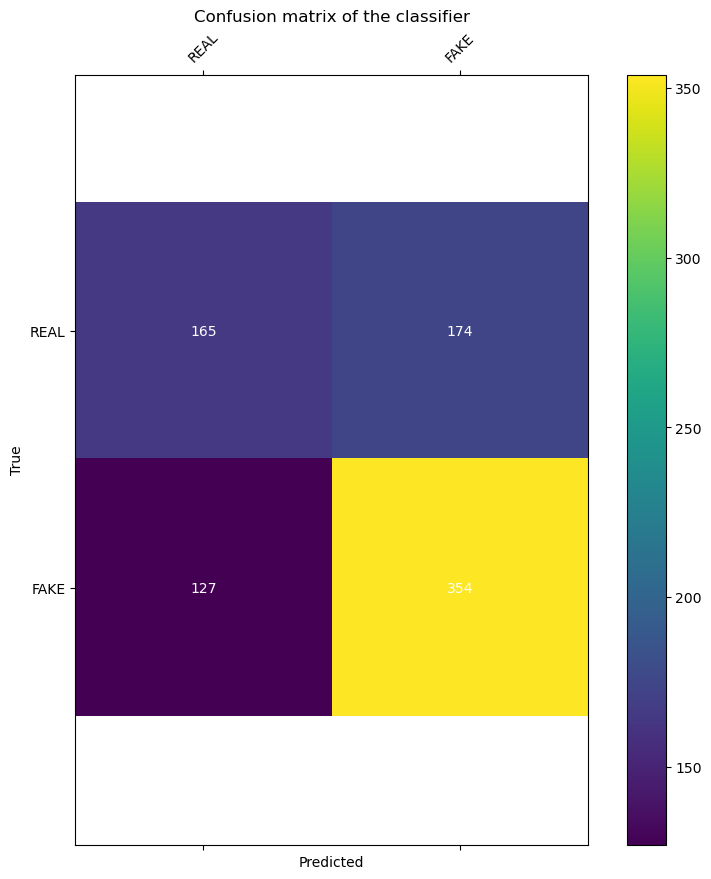

In [ ]:
folds = 10
fold_size = int(len(train_data)/folds) + 1
test_set = train_data[:fold_size]
train_set = train_data[fold_size:]
clf = train_classifier(train_set)
df = pd.DataFrame(test_set,columns=['statement','label'])
X = df['statement']
y  = df['label']
y_pred = predict_labels(X,clf)
label_names = ['REAL','FAKE']

confusion_matrix_heatmap(y, y_pred,label_names)

In [ ]:
# Saving the False positive and  False negative to text files
n = 820
with open('FAKE- flase negative.txt', 'w') as f:    
    for (text,subject, speaker, speaker_job,party_affiliation,state_info,label) in raw_data[:820]:
        prediction = predict_label_from_raw(text,subject, speaker, speaker_job,party_affiliation,state_info,clf)
        if(label=='FAKE' and prediction!=label):
            #print('{0} => {1}, ground truth = {2}'.format(text, prediction, label))
            print('{0} => {1}, ground truth = {2}'.format(text, prediction, label), file=f)
            n-=1
            if n <0:
                break
with open('FAKE- flase positives.txt', 'w') as f: 
    for (text,subject, speaker, speaker_job,party_affiliation,state_info,label) in raw_data[:820]:
        prediction = predict_label_from_raw(text,subject, speaker, speaker_job,party_affiliation,state_info,clf)
        if(label=='REAL'and prediction!=label):
            #print('{0} => {1}, ground truth = {2}'.format(text, prediction, label))
            print('{0} => {1}, ground truth = {2}'.format(text, prediction, label), file=f)
            n-=1
            if n <0:
                break

F-Score

In [ ]:
clf = train_classifier(train_data)
df = pd.DataFrame(test_data,columns=['statement','label'])
X = df['statement']
y  = df['label']
print(X)
y_pred = predict_labels(X,clf)
label_names = ['REAL','FAKE']

functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

Training Classifier...
0       {'the': 1, 'bush': 1, 'tax': 1, 'cut': 1, 'hel...
1       {'we': 1, 'have': 1, 'invested': 1, 'record': ...
2       {'$2': 1, '.': 1, '4': 1, 'million': 1, 'of': ...
3       {'says': 1, 'sen': 1, '.': 1, 'sherrod': 1, 'b...
4       {'half': 1, 'of': 1, 'illegal': 1, 'immigrant'...
                              ...                        
2044    {'there': 1, 'are': 1, 'a': 1, 'larger': 1, 'n...
2045    {'democrats': 1, 'have': 1, 'now': 1, 'become'...
2046    {'says': 1, 'an': 1, 'alternative': 1, 'to': 1...
2047    {'on': 1, 'lifting': 1, 'the': 1, 'u': 1, '.':...
2048    {'the': 1, 'department': 1, 'of': 1, 'veterans...
Name: statement, Length: 2049, dtype: object
({'the': 1, 'bush': 1, 'tax': 1, 'cut': 1, 'helped': 1, 'to': 1, 'create': 1, 'a': 1, 'substantial': 1, 'part': 1, 'of': 1, 'deficit': 1, '.': 1, 'the bush': 1, 'bush tax': 1, 'tax cut': 1, 'cut helped': 1, 'helped to': 1, 'to create': 1, 'create a': 1, 'a substantial': 1, 'substantial part': 